In [1]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv

from scipy import *
from scipy.linalg import norm, pinv
 

from sympy import symbols, diff
import matplotlib.pyplot as plt

In [14]:
def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,2))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err

In [15]:
np.random.seed(0)


#radial basis function compute exp(-beta * (c-x)^2)
def radialbasisfunc(beta, c, x):
    return exp(-beta * norm(c-x)**2)
     
#activation fills the Phi (in the pdf)
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    Phi = zeros((X.shape[0], numNeurons), float)
    for i, c in enumerate(centers):
        for j, x in enumerate(X):
            #Here we fill the element j,i with exp(-beta * (c_i-x_j)^2)
            Phi[j,i] = radialbasisfunc(beta, c, x)
    return Phi
     
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x 1
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    
    print "center", centers
    
    # calculate activations of RBFs
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis =1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
        
    # calculate output weights (pseudoinverse)
    W = dot(pinv(Phi), Y)
    
    #Calculate the covariance matrix Q
    Q = (dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y)))
    
    L = [W, Q, centers]
    
   
    print W
    print Q
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis=1)
    Y = dot(Phi, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    return Y

center [[-1.13131313 -1.13131313]
 [-2.18181818 -2.18181818]
 [-6.78787879 -6.78787879]
 [ 5.8989899   5.8989899 ]
 [ 3.95959596  3.95959596]
 [ 6.3030303   6.3030303 ]
 [-4.44444444 -4.44444444]
 [ 1.45454545  1.45454545]
 [ 3.47474747  3.47474747]
 [ 4.76767677  4.76767677]
 [-7.5959596  -7.5959596 ]
 [ 7.03030303  7.03030303]
 [ 5.33333333  5.33333333]
 [ 3.7979798   3.7979798 ]
 [ 6.62626263  6.62626263]
 [-3.31313131 -3.31313131]
 [ 2.58585859  2.58585859]
 [-6.14141414 -6.14141414]
 [ 2.02020202  2.02020202]
 [ 7.67676768  7.67676768]
 [-5.41414141 -5.41414141]
 [-0.16161616 -0.16161616]
 [ 0.72727273  0.72727273]
 [ 3.07070707  3.07070707]
 [ 4.28282828  4.28282828]]
[[-12.47938312]
 [ -3.75053387]
 [ -0.60557125]
 [  8.78849506]
 [-29.20990999]
 [-11.759314  ]
 [ -2.87477938]
 [ -2.98393552]
 [-38.40689346]
 [  7.64368057]
 [ -4.73713604]
 [ -1.31165711]
 [ -9.11822176]
 [ 53.11351245]
 [  5.13597894]
 [ -3.75889652]
 [-10.70006089]
 [ -2.94227752]
 [  5.00907417]
 [ -2.8360973

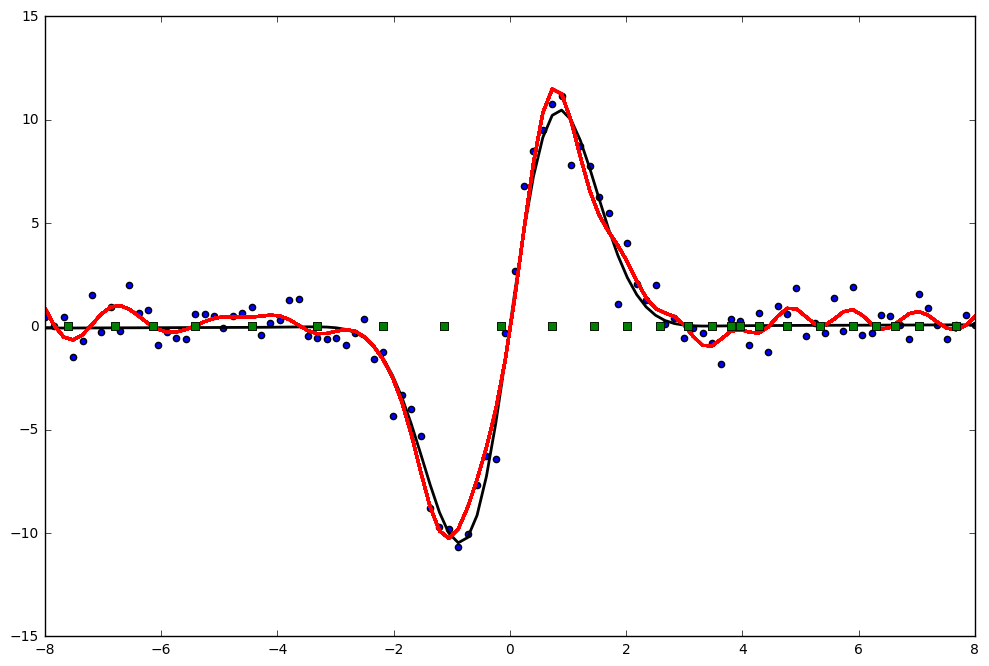

In [35]:
n = 100

#Specify Dimension of inputs and outputs
InputDimension = 1
OutputDimension = 1
     
#Define the bound of the focused interval    
lbound = -8
ubound = 8
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)
# set y and add random noise
    
    
#Function 1
yOriginal = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
#yOriginal = 0.9*x-50*np.exp(-x**2/2)+1

yNoisy = yOriginal + random.normal(0, 1, yOriginal.shape)

     
#Initialize parameters of the radial basis function
    
#Number of Gaussian centers(Neurons)
numNeurons = 25

#Define the size of the kernels 
beta = 1

######### Start RBF regression #############

#Train the neural network on the data x
parameters = trainrbf(x, yNoisy , beta, numNeurons)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])
       
# plot original data
plt.figure(figsize=(12, 8))

# plot original data
plt.plot(x,yOriginal, 'k-', linewidth=2)

for i in range(n):
    plt.scatter(x[i], yNoisy[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs')
     
plt.xlim(lbound, ubound)
plt.show()

#plt.savefig('graphs/RBF_2.jpg', format = 'jpg')